# Data Mining Project: Porto Seguro’s Safe Driver Prediction

## 1. Introduction

This project tackles the "Porto Seguro’s Safe Driver Prediction" challenge hosted on Kaggle. 
The primary business objective is to build a machine learning model that accurately predicts the probability that a driver will file an insurance claim within the next year. 
By identifying high-risk drivers, Porto Seguro, one of Brazil's largest auto and homeowner insurance companies, can improve its pricing models, risk assessment, and decision-making processes.

## 2. Data Overview

### 2.1. Import packages

In [75]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.utils import resample

pd.set_option('display.max_columns', 100)

### 2.2. Loading data

In [90]:
data = pd.read_csv('./data/train.csv')

In [40]:
data.shape

(595212, 59)

In [41]:
data.drop_duplicates()
data.shape

(595212, 59)

There is no duplicate.

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [43]:
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


Observation:
* Features are grouped into **ind, reg, car, calc**.
* Feature include the postfix **bin** have binary value and **cat** are categorical features. 
* Features **without postfix are either continuous or ordinal**. 
* Values **-1**  = **null**.

### 2.3. Metadata

For efficent management over 59 features, I decided to create a dataframe to store the metadata. This could be helpful if we want to select specific variable for analysis, visualizations, ....

The metadata includes:
- **role**: id, target, input.
- **level**: binary, categorical, continuos, ordinal.
- **keep**: to keep or not (True, False).
- **dtype**: data type.

In [91]:
metadata = []
for f in data.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'categorical'
    elif data[f].dtype == float:
        level = 'continuos'
    elif data[f].dtype == int:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type 
    dtype = data[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    metadata.append(f_dict)
    
meta = pd.DataFrame(metadata, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [45]:
meta

,role,level,keep,dtype
varname,,,,
id,id,categorical,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,categorical,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,categorical,True,int64
ps_ind_05_cat,input,categorical,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


Check if metadata is working.

In [46]:
meta[(meta.level == 'categorical') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [47]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,continuos,10
4,input,ordinal,16
5,target,binary,1


### 2.4. Descriptive statistics

I wanted to use the *describe()* method to generate summary statistics. However, this method is not meaningful for categorical variables, so I will exclude all categorical features and apply it only to numerical variables.

#### 2.4.1. Continuos variables

In [48]:
v = meta[(meta.level == 'continuos') & (meta.keep)].index
data[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


As i mentioned, -1 represent for null value. Therefore, we can see that:

#### reg variables
- only ps_reg_03 has missing values

#### car variables
- ps_car_12 and ps_car_15 have missing 

#### calc variables
- no missing values


### 2.4.2. Ordinal variables

In [49]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
data[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- Only one missing variable: ps_car_11

### 2.4.3. Binary variables

In [50]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
data[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- There is no missing values.
- Proportion of target=1 is 3.64% (which is mean).

### 2.5 Individual Feature Visualizations
I am going to visualize all features to gain a better understanding of the data.

#### 2.5.1. Categorical Variables

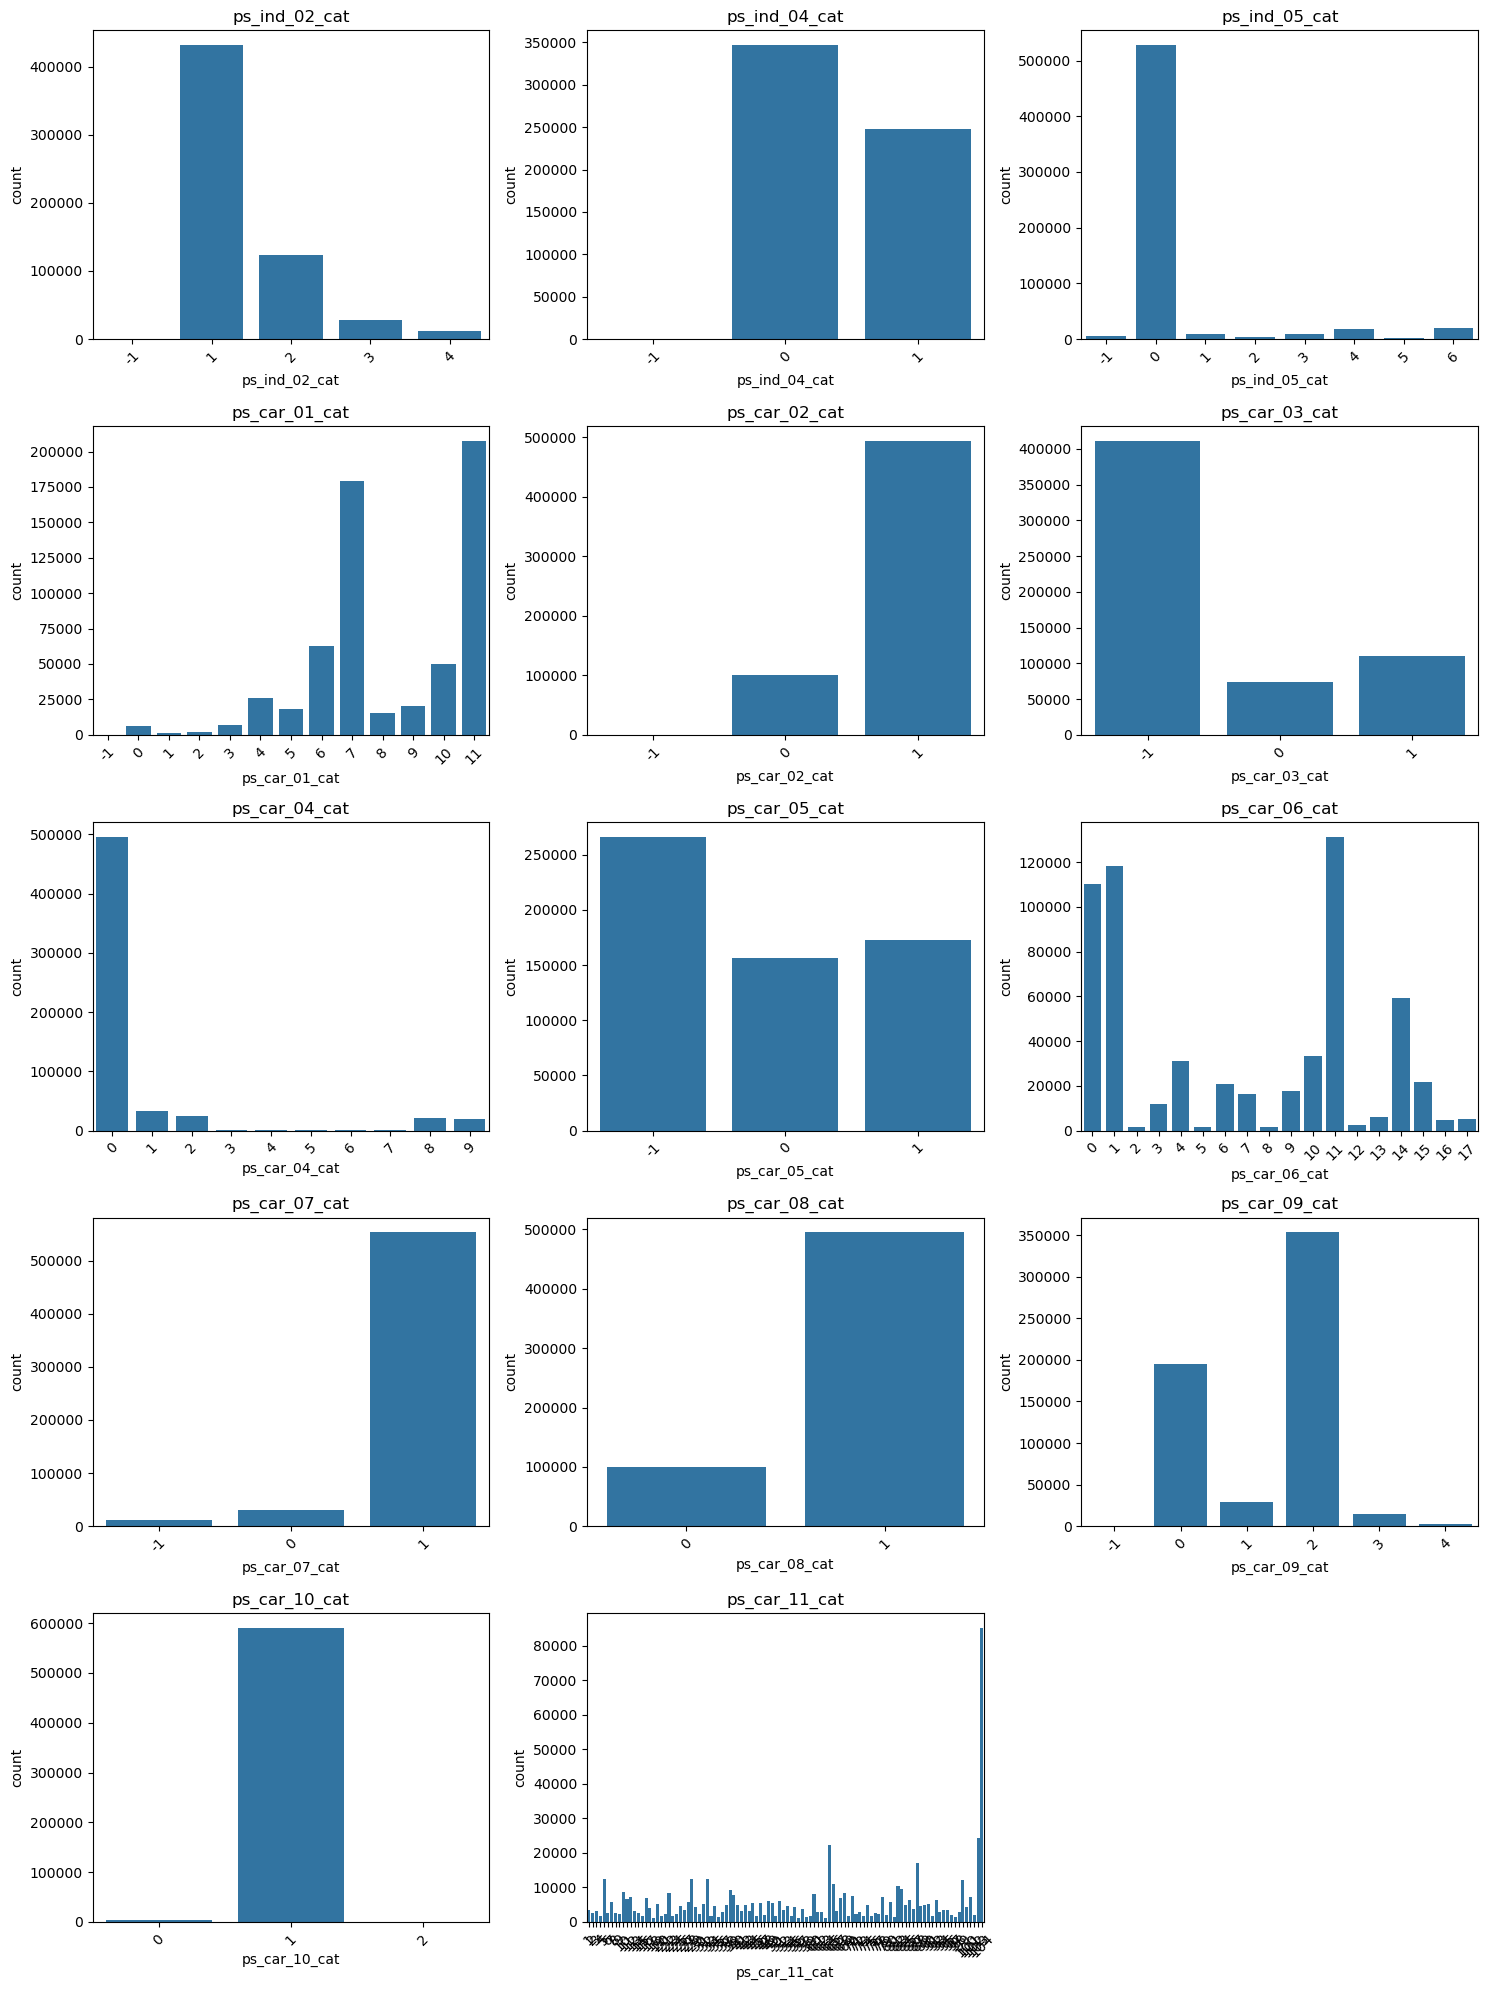

In [51]:
cat_features = meta[(meta.level == 'categorical') & (meta.keep)].index
n = len(cat_features)
cols = 3 
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, f in enumerate(cat_features):
    sns.countplot(x=f, data=data, ax=axes[i])
    axes[i].set_title(f'{f}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- **ps_car_10_cat** contain mostly value 1, it's considered to be removed
- **ps_car_06_cat, ps_car_11_cat** have many distinct values.

Since these categorical features are numerically encoded, I will apply one-hot encoding (dummifying) so that the models do not misinterpret them as ordinal variables.

#### 2.5.2. Continuos Variables

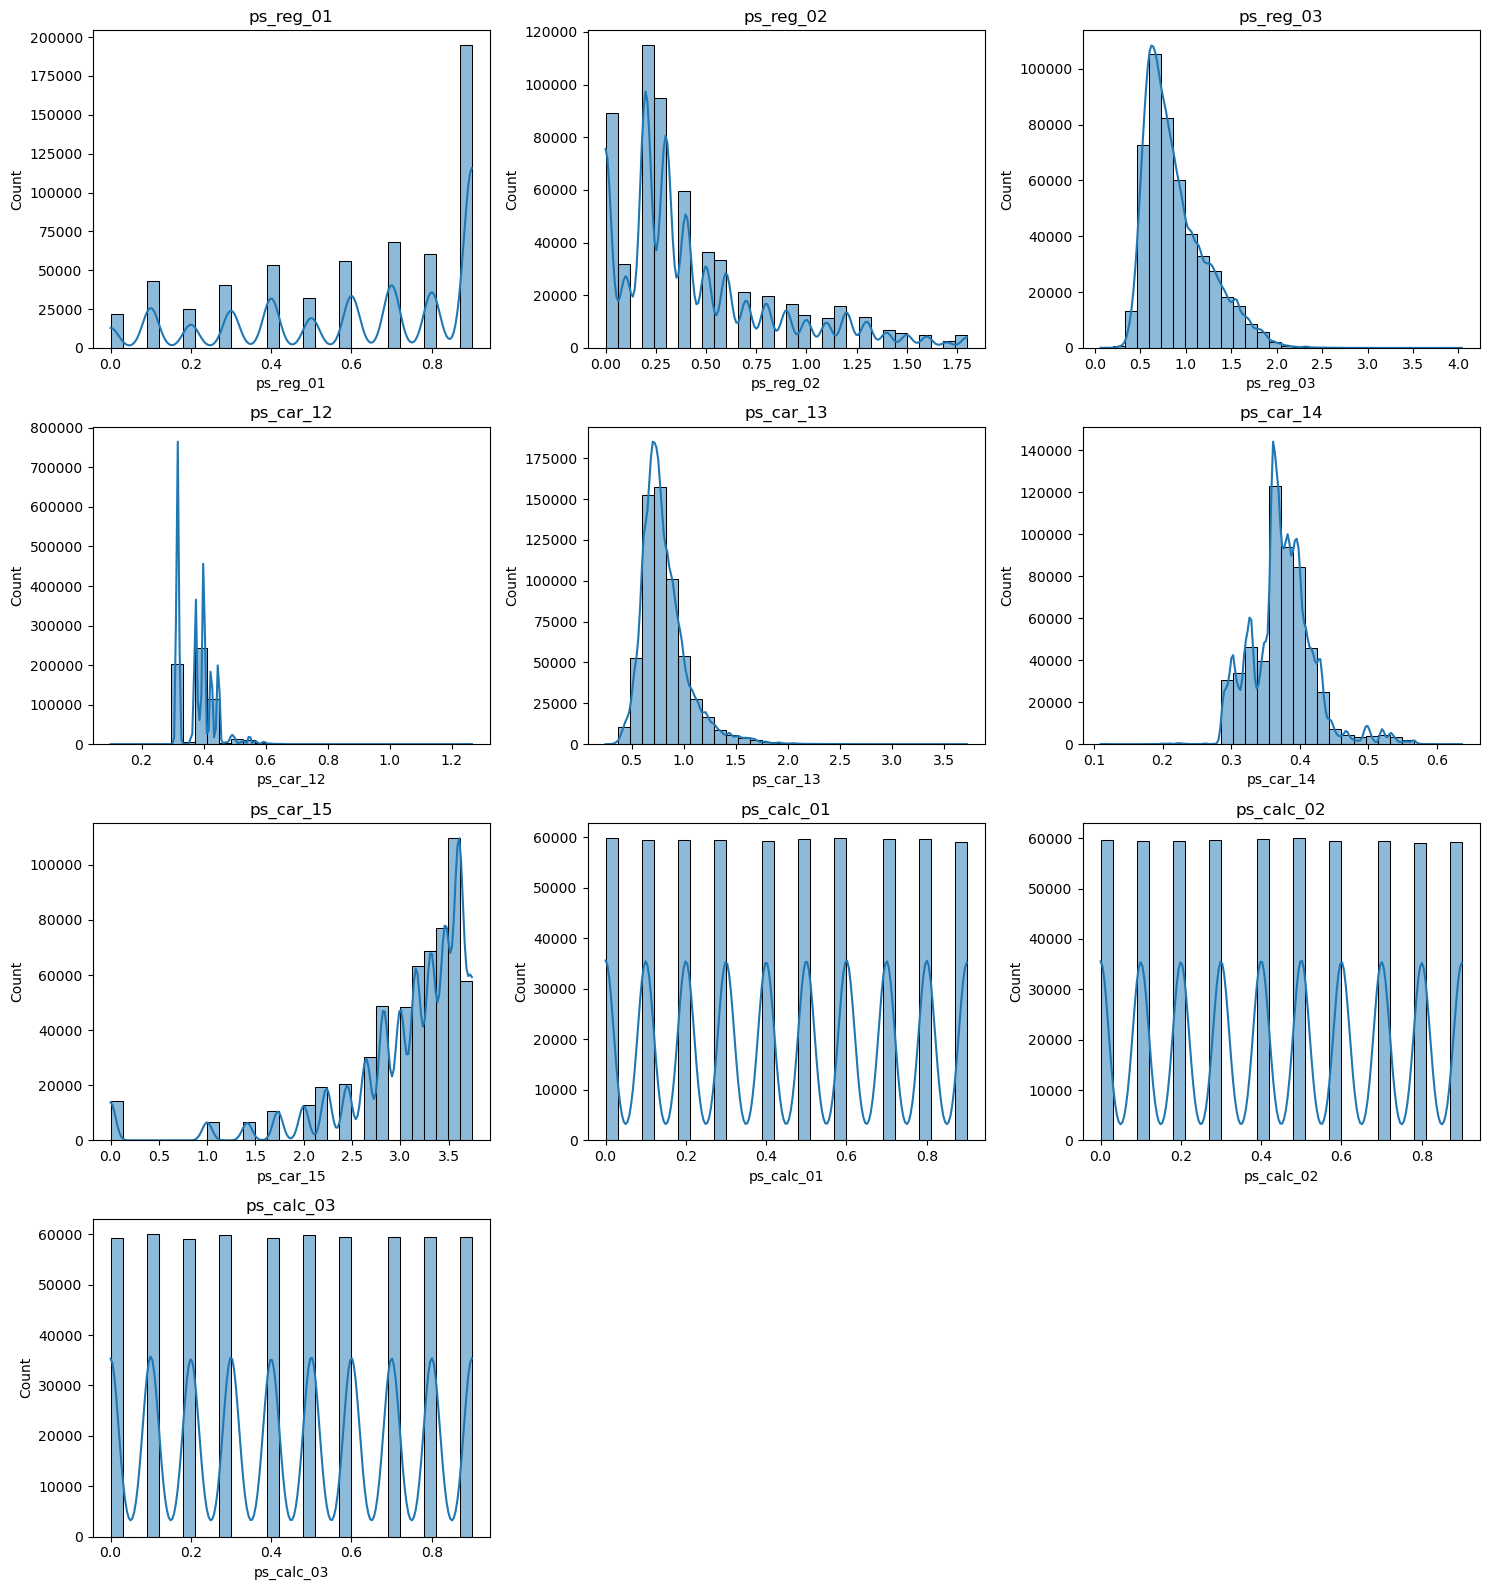

In [52]:
v = meta[(meta.level == 'continuos') & (meta.keep)].index
n = len(v)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

data_cont = data[v].replace(-1, np.nan)

for i, f in enumerate(v):
    sns.histplot(data_cont[f].dropna(), ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- All of continous **calc** features distribute evenly

#### 2.5.3. Binary Variables

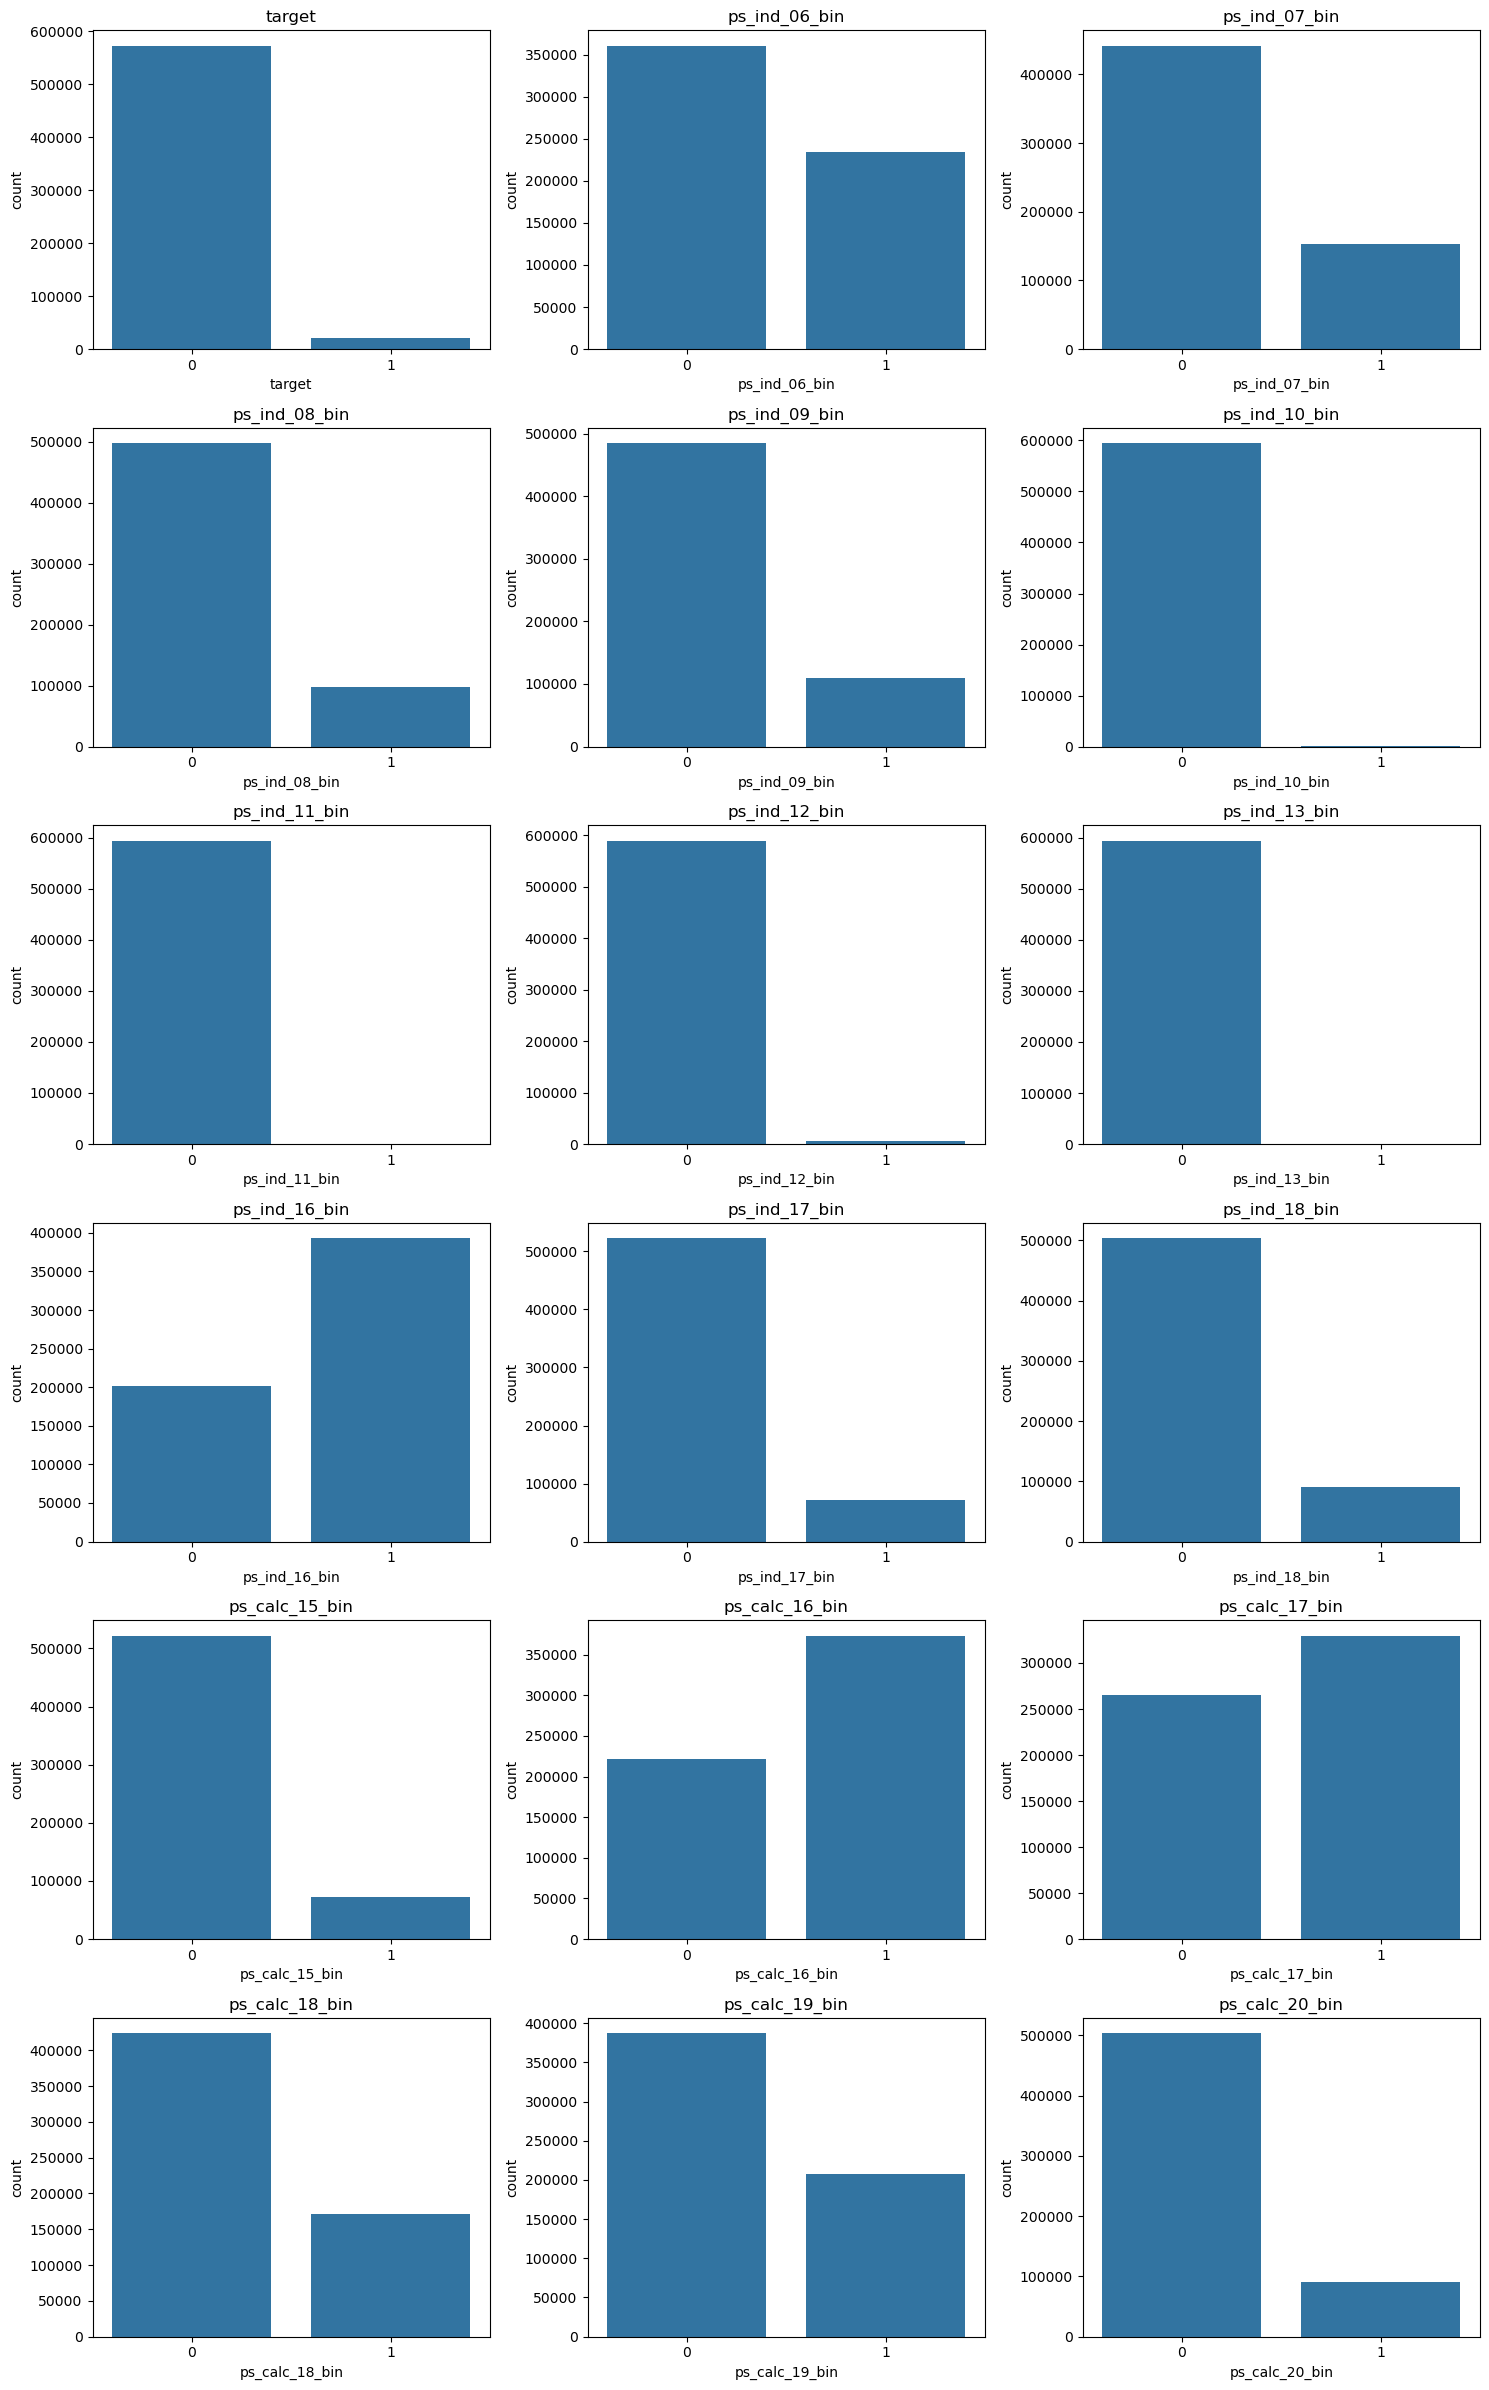

In [53]:
binary_features = meta[(meta.level == 'binary') & (meta.keep)].index
n = len(binary_features)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, f in enumerate(binary_features):
    ax = sns.countplot(x=f, data=data, ax=axes[i])
    axes[i].set_title(f'{f}')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- **ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin** have very low variance, with most values being 0 and very few 1. They carry little information for distinguishing target classes and can be considered for removal.

#### 2.5.4. Ordinal Variables

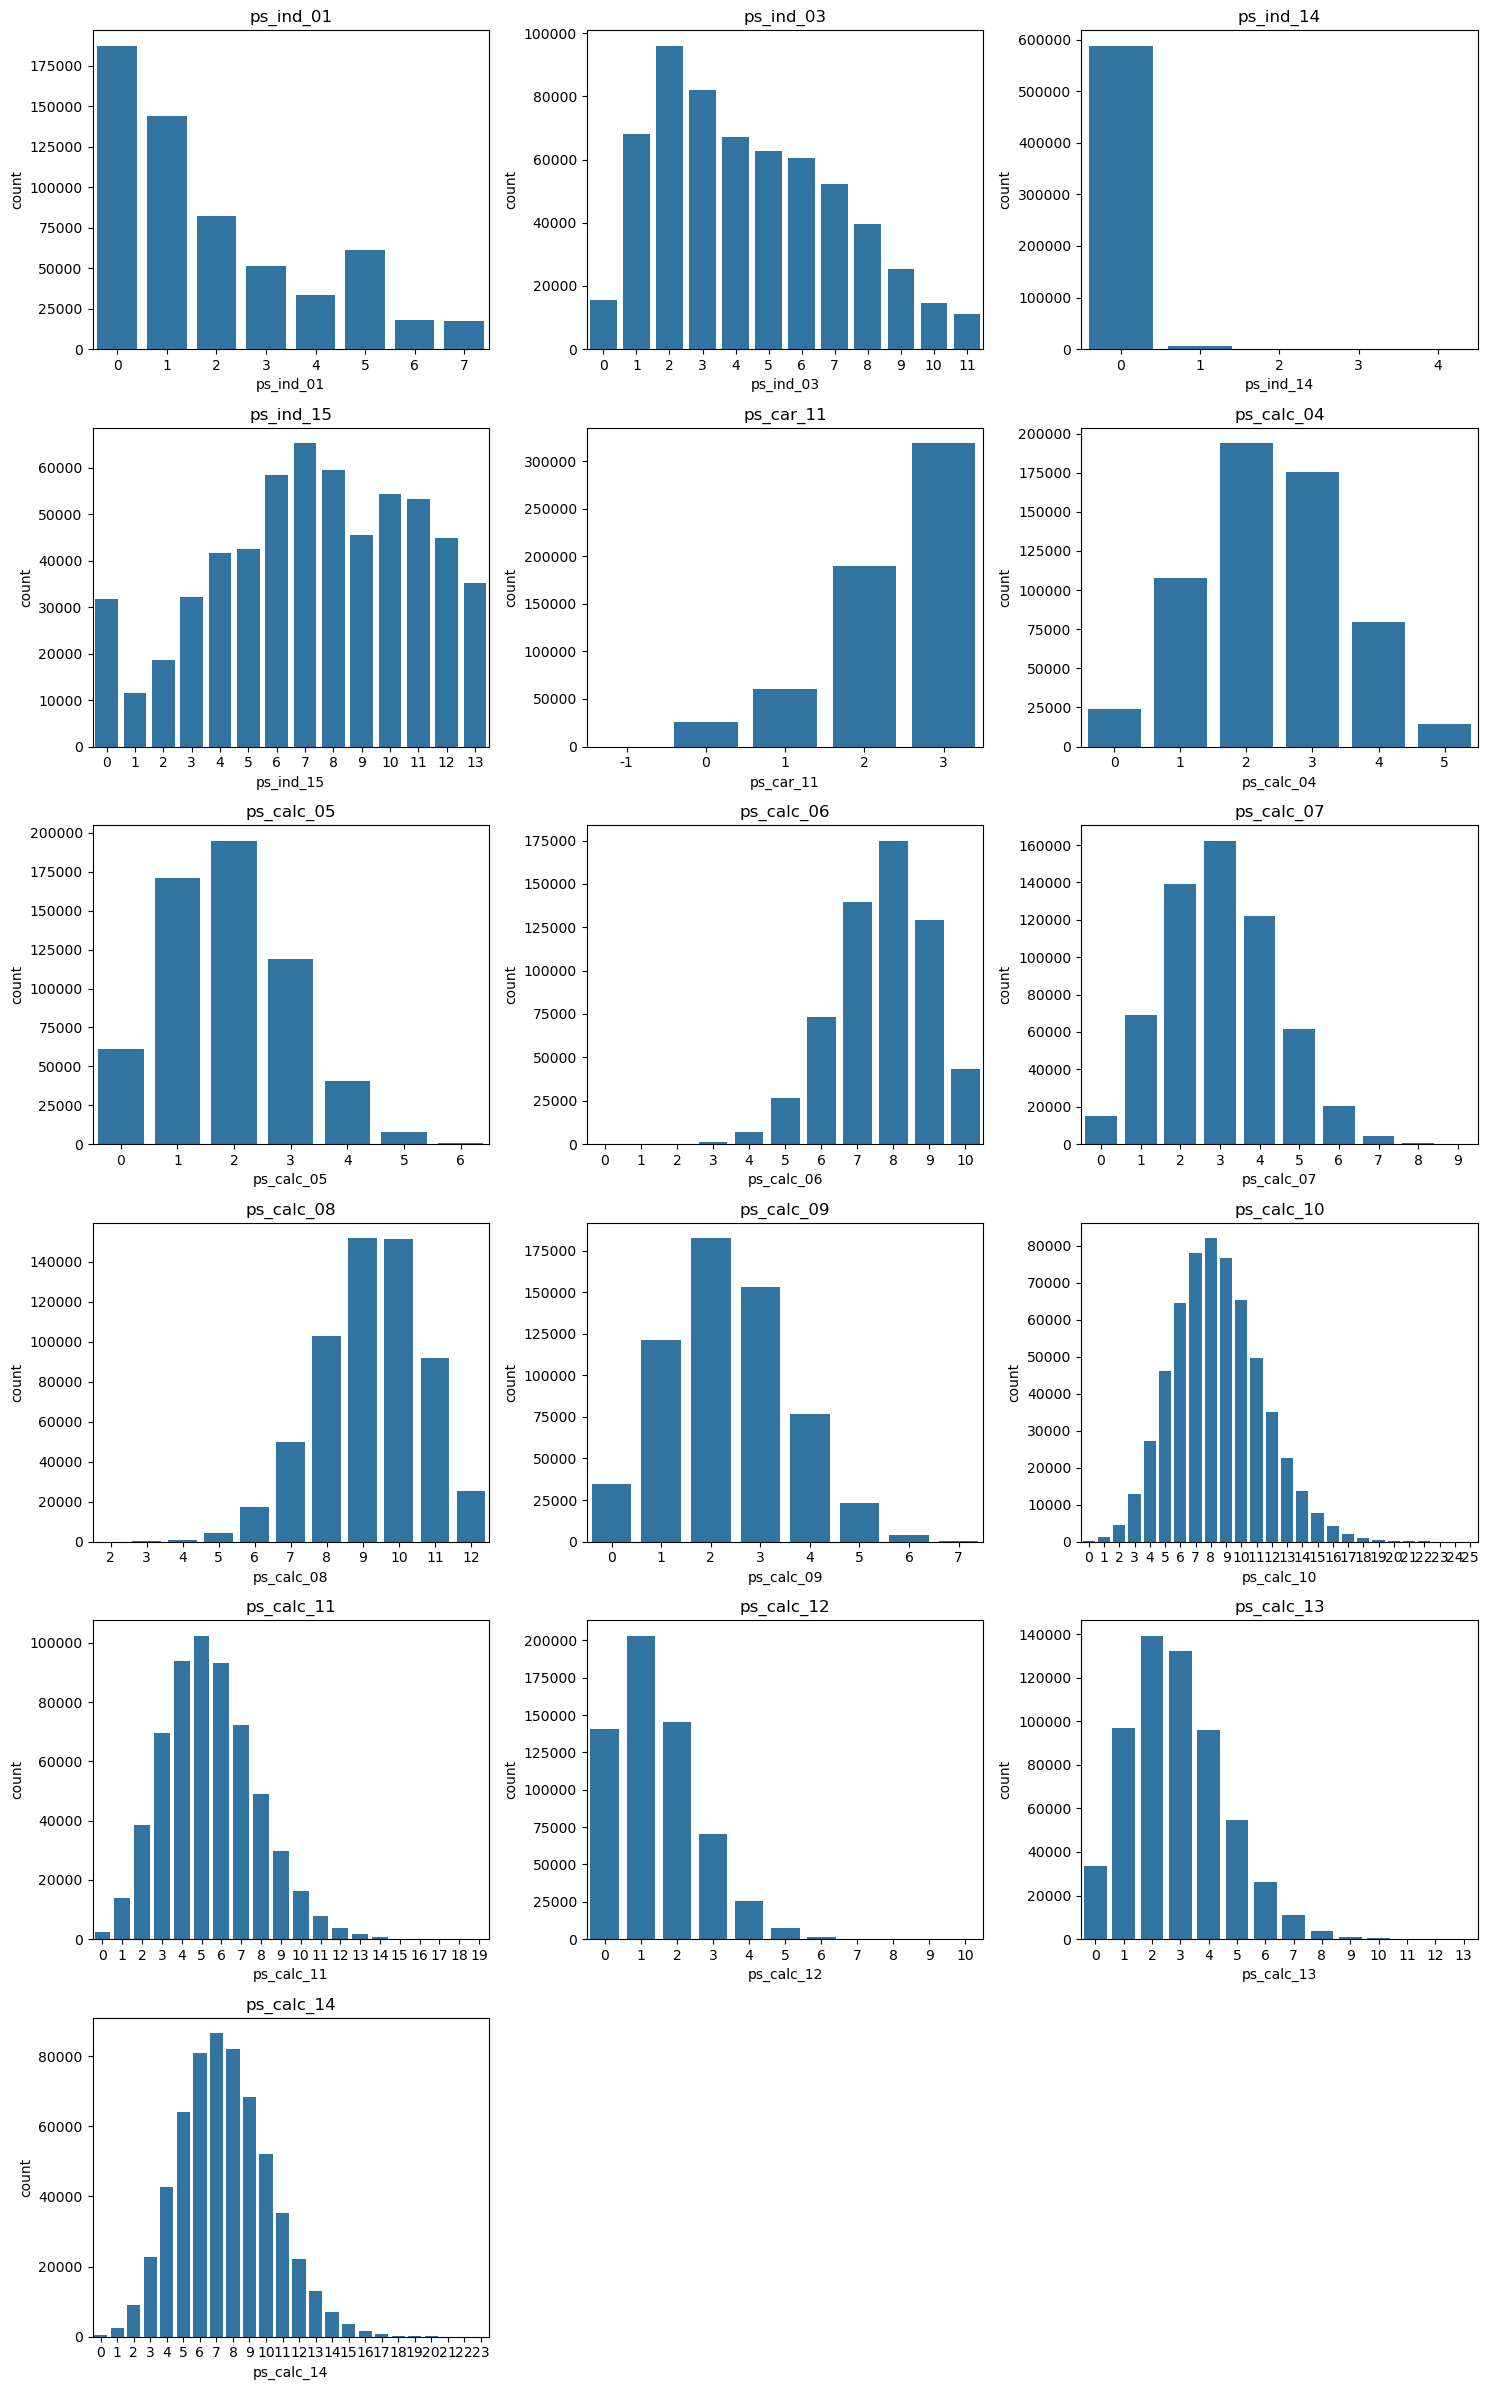

In [54]:
ordinal_features = meta[(meta.level == 'ordinal') & (meta.keep)].index
n = len(binary_features)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, f in enumerate(ordinal_features):
    ax = sns.countplot(x=f, data=data, ax=axes[i])
    axes[i].set_title(f'{f}')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 2.5.5. Target

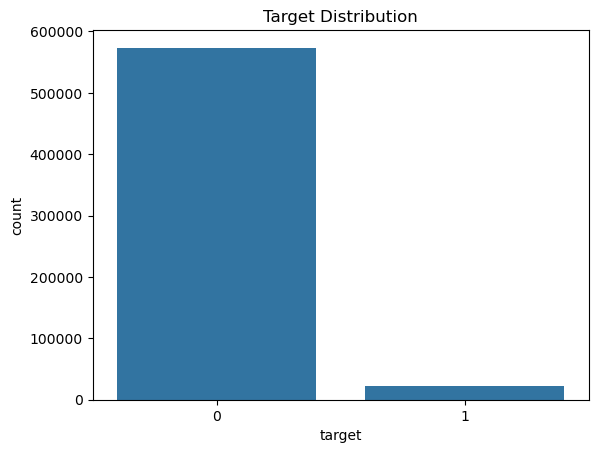

Ratio of Target 0: 96.36%
Ratio of Target 1: 3.64%


In [27]:
sns.countplot(x='target', data=data)
plt.title('Target Distribution')
plt.show()

target_pct = (data['target'].value_counts() / len(data)) * 100
print(f"Ratio of Target 0: {target_pct[0]:.2f}%")
print(f"Ratio of Target 1: {target_pct[1]:.2f}%")

## 3. Data Preparation

To avoid data leakage, I split the dataset into train and test datasets.
- train/test = 80/20

In [92]:
X = data.drop(columns=['target'])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train = X_train.copy()
train['target'] = y_train

test = X_test.copy()
test['target'] = y_test

print(f"Train set size: {train.shape}")
print(f"Test set size: {test.shape}")

Train set size: (476169, 59)
Test set size: (119043, 59)


### 3.1. Handling missing values
Missings are represented as -1

In [93]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/data.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 165 records (0.03%) with missing values
Variable ps_ind_04_cat has 62 records (0.01%) with missing values
Variable ps_ind_05_cat has 4607 records (0.77%) with missing values
Variable ps_reg_03 has 86269 records (14.49%) with missing values
Variable ps_car_01_cat has 84 records (0.01%) with missing values
Variable ps_car_02_cat has 4 records (0.00%) with missing values
Variable ps_car_03_cat has 329080 records (55.29%) with missing values
Variable ps_car_05_cat has 213124 records (35.81%) with missing values
Variable ps_car_07_cat has 9161 records (1.54%) with missing values
Variable ps_car_09_cat has 458 records (0.08%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_14 has 34176 records (5.74%) with missing values
In total, there are 12 variables with missing values


- **ps_car_03_cat and ps_car_05_cat** have a large proportion of  records with missing values. Remove these variables.
- Other categorical variables **(ps_ind_02_cat, ps_ind_04_cat, ps_ind_05_cat, ps_car_01_cat, ps_car_02_cat, ps_car_07_cat, ps_car_09_cat)** have low missing (<2%). Keep -1 as a “missing” category.
- Continuous variables **ps_reg_03** and **ps_car_14** has missing values for 14.49% and 5.74% of all records. Replace by the mean.
- Ordinal variable **ps_car_11** has only 5 missing records. Replace with mode.

In [94]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, axis=1, inplace=True)
test.drop(vars_to_drop, axis=1, inplace=True)

meta.loc[(vars_to_drop),'keep'] = False  # Updating the meta

In [96]:
# Imputing with the mean or mode
mean_imp_reg03 = SimpleImputer(missing_values=-1, strategy='mean')
mean_imp_car14 = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp_car11 = SimpleImputer(missing_values=-1, strategy='most_frequent')

# Train set
train['ps_reg_03'] = mean_imp_reg03.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_14'] = mean_imp_car14.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp_car11.fit_transform(train[['ps_car_11']]).ravel()

# Test set
test['ps_reg_03'] = mean_imp_reg03.transform(test[['ps_reg_03']]).ravel()
test['ps_car_14'] = mean_imp_car14.transform(test[['ps_car_14']]).ravel()
test['ps_car_11'] = mode_imp_car11.transform(test[['ps_car_11']]).ravel()

print(f"Train set size: {train.shape}")
print(f"Test set size: {test.shape}")

Train set size: (476169, 57)
Test set size: (119043, 57)


### 3.2. Multi-Feature Visualizations
I used heatmap to visualize the correlation between variables. However, for binary and categorical variables, this measure would not be meaningful because their values are discrete and do not have inherent numerical relationships.

#### 3.2.1. Corellations between Continuos variables

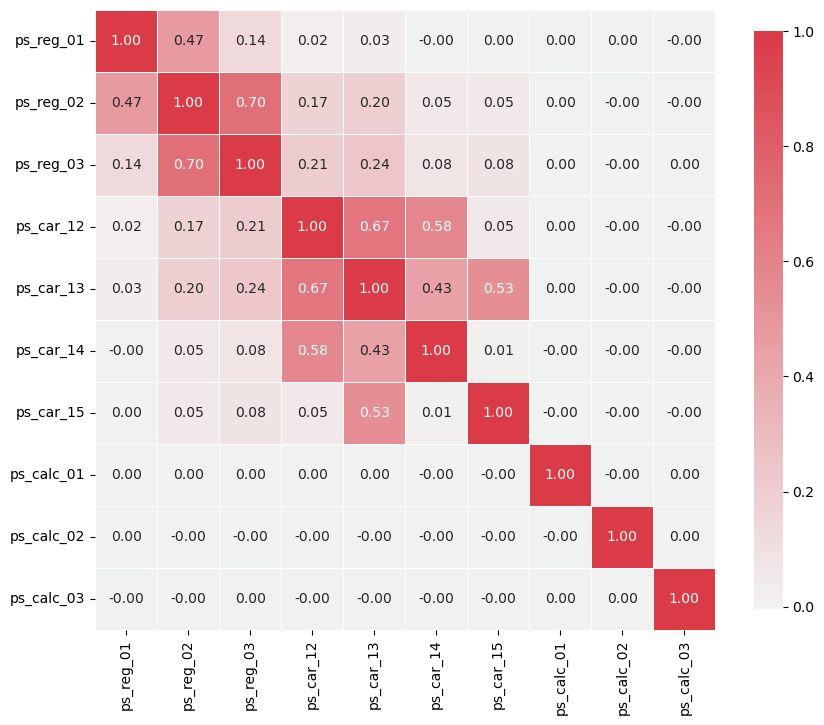

In [65]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show()
    
v = meta[(meta.level == 'continuos') & (meta.keep)].index
corr_heatmap(v)

There are noticeable correlations between the variables:
- ps_reg_02 and ps_reg_03 (0.7)
- ps_car_12 and ps_car13 (0.67)
- ps_car_12 and ps_car14 (0.58)
- ps_car_13 and ps_car15 (0.53)

Because the correlations are not too strong, so i decide to do nothing.

#### 3.2.2. Correlations between Ordinal variables

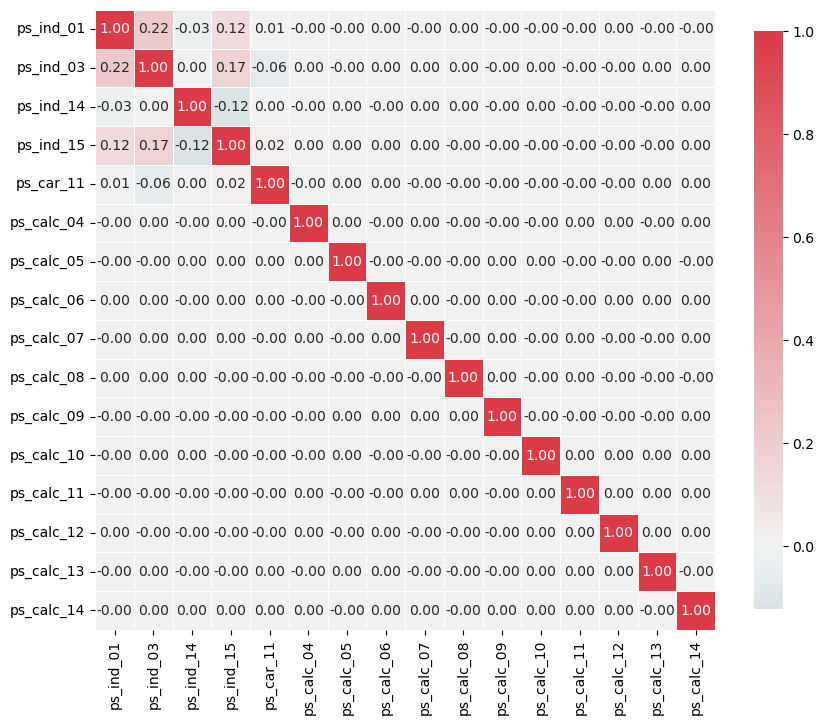

In [66]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

For the ordinal variables, there are not any strong correlations.

### 3.3. Removing features with low or zero variance

I use **VarianceThreshold** to decide which features to remove. By default it removes features with zero variance. However, as I saw there are no zero-variance variables in the previous steps. Therefore, I remove features with less than 1% variance.

In [97]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to data without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

7 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_10_cat', 'ps_car_12', 'ps_car_14']


In [98]:
train.drop(columns=v, inplace=True)
test.drop(columns=v, inplace=True)
meta.loc[v, 'keep'] = False

Finally, i drop the id column because it has unique values and seem to be useless.

In [99]:
train.drop(columns='id', inplace=True)
test.drop(columns='id', inplace=True)

print(f"Train set size: {train.shape}")
print(f"Test set size: {test.shape}")

Train set size: (476169, 49)
Test set size: (119043, 49)


### 3.4. Encoding Categorical Features

#### 3.4.1. Frequency Encoding for *ps_car_11_cat*
**ps_car_11_cat** is a categorical feature with high cardinality, meaning it has many distinct categories. If I apply one-hot encoding, it would create a large number of new columns, increasing memory usage and the risk of overfitting. To address this, I use frequency encoding, which converts each category into a numeric value representing its frequency in the training set.

- Each category is replaced by the proportion of records in the train dataset that belong to that category.
- Any new categories appearing in the test set that were not seen in train are assigned 0.

In [100]:
# Calc frequency for each category
freq = train['ps_car_11_cat'].value_counts() / len(train)

# Map it and fill NaN in test (rare category)
train['ps_car_11_cat_fe'] = train['ps_car_11_cat'].map(freq)
test['ps_car_11_cat_fe']  = test['ps_car_11_cat'].map(freq).fillna(0)

train.drop('ps_car_11_cat', axis=1, inplace=True)
test.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat', 'keep'] = False

train['ps_car_11_cat_fe'].head()

520363    0.142596
271468    0.012993
575806    0.004717
145105    0.020997
31107     0.010673
Name: ps_car_11_cat_fe, dtype: float64

#### 3.4.2. One-hot Encoding for Other Categorical Features
One-hot encoding (also called dummifying) is a technique to convert categorical variables into a format that can be provided to machine learning algorithms.
- Each category in a categorical feature is transformed into a binary (0/1) column.
- A value of 1 indicates the observation belongs to that category, and 0 indicates it does not.
- This method avoids the model assuming any ordinal or numeric relationship between categories.

In [101]:
v = meta[(meta.level == 'categorical') & (meta.keep)].index

print('Before dummification we have {} variables in train and test'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
test = pd.get_dummies(test, columns=v, drop_first=True)
print('After dummification we have {} variables in train and test'.format(train.shape[1]))

Before dummification we have 49 variables in train and test
After dummification we have 100 variables in train and test


### 3.5. Continuos Features Scaling
Continuous features were standardized using StandardScaler to ensure they are on a comparable scale. Although the original values were not extremely different, scaling helps the model train more efficiently by improving numerical stability and ensuring that no single feature dominates due to its magnitude.

In [103]:
cont_vars = meta[(meta.level == 'continuos') & (meta.keep)].index

scaler = StandardScaler()

train[cont_vars] = scaler.fit_transform(train[cont_vars])
test[cont_vars] = scaler.transform(test[cont_vars])

train[cont_vars].head()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_13,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
520363,-0.037899,1.632043,-6.061605e-01,-0.967319,-1.823762,0.521808,-1.218735,-0.870322
271468,-1.428243,-0.345034,-3.409490e-16,-0.373325,0.131545,0.869858,-1.218735,1.219683
575806,0.657273,1.879178,1.633885e+00,-0.338005,-0.324872,-0.870392,-0.870165,0.523015
145105,1.004859,1.384909,-3.409490e-16,0.744585,0.131545,-0.522342,0.524118,0.523015
31107,0.309687,0.396370,8.147114e-01,-0.617973,-0.842929,1.565958,-1.567306,-0.173654


### 3.6. Handling Imbalanced Dataset
As I mentioned earlier, this dataset is imbalanced, meaning that the number of samples in the positive class is significantly smaller than in the negative class. When a dataset is highly imbalanced, a model can easily achieve high accuracy simply by predicting the majority class for most observations. Although such a model may appear to perform well according to the accuracy metric, it actually provides little meaningful value because it fails to correctly identify the minority class, which is usually the class of interest.

To fix it, I want to apply **oversampling** for not losing data with apriori = 0.15.

<img src="https://miro.medium.com/max/725/0*FeIp1t4uEcW5LmSM.png" width="800">

In [104]:
desired_apriori = 0.15


train_0 = train[train.target == 0]
train_1 = train[train.target == 1]

n0 = len(train_0)
n1 = len(train_1)
print(f'Number of records with target=1 before: {n1}')

# n1_new / n1_new + n0 = a
# n1_new = a*n1_new + a*n0
# n1_new = a*n0 / (1 - a)

n1_new = int((desired_apriori * n0) / (1 - desired_apriori))
print(f"Number of records with target=1 after oversampling: {n1_new}\n")

train_1_oversampled = resample(train_1, replace=True, n_samples=n1_new, random_state=42)
train_oversampled = pd.concat([train_0, train_1_oversampled])

# Shuffle the new dataset to mix the records
train = train_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"New 'train_oversampled' dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}")
print(f"New target distribution in 'train_oversampled': {train['target'].value_counts(normalize=True)}")

Number of records with target=1 before: 17355
Number of records with target=1 after oversampling: 80967

New 'train_oversampled' dataset shape: (539781, 100)
Test dataset shape: (119043, 100)
New target distribution in 'train_oversampled': target
0    0.85
1    0.15
Name: proportion, dtype: float64


## 4. Modelling

### 4.1. Model Selection
I use these models:
- Logistic Regression
- K-Nearest Neighbors
- Gaussian Naive Bayes
- Decision Tree
- Random Forest

To find the best model.

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train.drop(columns=['target'])
y_train = train['target']

X_test = test.drop(columns=['target'])
y_test = test['target']

models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gaussian Naive Bayes': GaussianNB()
}

model_scores_acc = {}
model_scores_recall_1 = {}

print("--- START TRAINING AND COMPARISON ---")
for model_name, model in models.items():
    print(f"\n--- Training: {model_name} ---")

    model.fit(X_train, y_train)
    # Evaluate trên test gốc (không oversample)
    y_pred = model.predict(X_test)

    # Calculate performance
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    recall_1 = report.get('1', {}).get('recall', 0.0)

    model_scores_acc[model_name] = acc
    model_scores_recall_1[model_name] = recall_1

    # Print results
    print(f"  >>> Accuracy : {acc:.4f}")
    print(f"  >>> Recall(1): {recall_1:.4f}")
    print("  Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

print("\n=== RESULTS ===")
scores_df = pd.DataFrame({
    'Model': list(model_scores_acc.keys()),
    'Accuracy': list(model_scores_acc.values()),
    'Recall (Class 1)': list(model_scores_recall_1.values())
})

print(scores_df.sort_values(by="Recall (Class 1)", ascending=False))

aaa
--- START TRAINING AND COMPARISON ---

--- Training: Logistic Regression ---
  >>> Accuracy : 0.9631
  >>> Recall(1): 0.0051
  Confusion Matrix:
[[114627     77]
 [  4317     22]]

--- Training: KNN (k=5) ---
  >>> Accuracy : 0.8906
  >>> Recall(1): 0.0952
  Confusion Matrix:
[[105601   9103]
 [  3926    413]]

--- Training: Decision Tree ---
  >>> Accuracy : 0.9238
  >>> Recall(1): 0.0537
  Confusion Matrix:
[[109741   4963]
 [  4106    233]]

--- Training: Random Forest ---
  >>> Accuracy : 0.9636
  >>> Recall(1): 0.0000
  Confusion Matrix:
[[114704      0]
 [  4339      0]]

--- Training: Gaussian Naive Bayes ---
  >>> Accuracy : 0.8209
  >>> Recall(1): 0.2648
  Confusion Matrix:
[[96572 18132]
 [ 3190  1149]]

=== RESULTS ===
                  Model  Accuracy  Recall (Class 1)
4  Gaussian Naive Bayes  0.820888          0.264808
1             KNN (k=5)  0.890552          0.095183
2         Decision Tree  0.923817          0.053699
0   Logistic Regression  0.963089          0.005

### 4.2. Naive Bayes Probability-Based Prediction and Threshold Tuning
Naive Bayes was selected because it achieved the highest Recall among the tested models. However, both Recall and Accuracy remain relatively low, largely due to the imbalanced dataset, where the minority class (class 1) has very few samples compared to the majority class (class 0).

To improve performance, instead of using the default threshold of 0.5, I apply probability-based predictions (predict_proba) for class 1 and perform threshold tuning based on F1 score. The goal is to find the optimal classification threshold that balances Recall (correctly identifying class 1) and Precision (minimizing false positives), thereby maximizing the F1 score for the minority class. This approach allows the model to be more sensitive to the minority class while still considering the overall prediction quality.

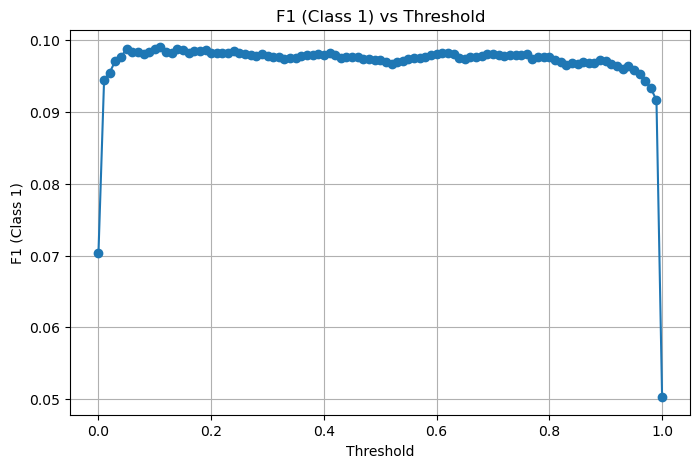

Best threshold for F1 (class 1): 0.11
F1 score at best threshold: 0.0990
Confusion Matrix at best threshold:
[[90502 24202]
 [ 2852  1487]]
Accuracy at best threshold: 0.7727
Recall (Class 1) at best threshold: 0.3427


In [115]:
from sklearn.metrics import recall_score, f1_score

model = GaussianNB()
model.fit(X_train, y_train)

# Predict probabilities cho class 1
y_proba = model.predict_proba(X_test)[:, 1]

# Khai báo các threshold từ 0.0 -> 1.0
thresholds = np.linspace(0, 1, 101)
f1_scores = []

# Tính F1 cho class 1 với từng threshold
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    f1_scores.append(f1)

# Vẽ curve F1(class 1) theo threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1 (Class 1) vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 (Class 1)')
plt.grid(True)
plt.show()

# Chọn threshold tối ưu theo F1 cao nhất
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold for F1 (class 1): {best_threshold:.2f}")
print(f"F1 score at best threshold: {best_f1:.4f}")

# Dự đoán với threshold tối ưu
y_pred_best = (y_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix at best threshold:")
print(cm)

acc = accuracy_score(y_test, y_pred_best)
recall_1 = recall_score(y_test, y_pred_best, pos_label=1)

print(f"Accuracy at best threshold: {acc:.4f}")
print(f"Recall (Class 1) at best threshold: {recall_1:.4f}")